In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
import os


In [41]:
def get_neighbors(i, j, N):
    return [
        (ni, nj)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
        if 0 <= (ni := i + dx) < N and 0 <= (nj := j + dy) < N
    ]

def count_active_neighbors(i, j, state):
    """
    Count number of active 4-connected neighbors of cell (i, j).
    """
    N = state.shape[0]
    return sum(state[ni, nj] for (ni, nj) in get_neighbors(i, j, N))


In [42]:
def initialize_grid(N, seed_coords, humidity_fn=None):
    if humidity_fn is None:
        humidity_fn = lambda: np.random.rand()

    humidity = np.array([[humidity_fn() for _ in range(N)] for _ in range(N)], dtype=float)
    humidity = np.clip(humidity, 0.0, 1.0)

    state = np.zeros((N, N), dtype=bool)
    frontier = set()

    for (i, j) in seed_coords:
        state[i, j] = True
        for ni, nj in get_neighbors(i, j, N):
            if not state[ni, nj]:
                frontier.add((ni, nj))

    return humidity, state, frontier


In [47]:
def grow_cloud(humidity, state, frontier):
    """
    Persistent, correct frontier tracking:
    - Activates frontier cells probabilistically.
    - Adds inactive neighbors of newly activated cells to the next frontier.
    - Retains still-inactive frontier cells.
    """
    N = state.shape[0]
    next_frontier = set()

    for (i,j) in frontier:
        prob = humidity[i,j]
        active_ns = count_active_neighbors(i,j,state)
        bias_arr = [0,1,0.5,0.2,0.1]
        prob = prob * bias_arr[active_ns]
        if np.random.rand() < prob:
            state[i, j] = True
            for (ni, nj) in get_neighbors(i,j,N):
                if not state[ni,nj]:
                    next_frontier.add((ni,nj))
        else: next_frontier.add((i,j))    

    return state, next_frontier



In [48]:
def run_simulation(N, seed_coords, iterations, humidity_fn=None):
    humidity, state, frontier = initialize_grid(N, seed_coords, humidity_fn)
    states = [state.copy()]
    frontiers = [set(frontier)]  # Capture a copy

    for _ in range(iterations):
        state, frontier = grow_cloud(humidity, state, frontier)
        states.append(state.copy())
        frontiers.append(set(frontier))  # Store snapshot of frontier

    return humidity, states, frontiers


In [49]:
def plot_state(state, title=None, save_path=None):
    plt.figure(figsize=(6,6))
    plt.imshow(state, cmap='Blues', interpolation='none')
    plt.title(title or "Cloud State")
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()

def save_animation(states, out_dir='out', filename=None):
    os.makedirs(out_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = filename or f"cloud_growth_{timestamp}.gif"
    filepath = os.path.join(out_dir, filename)

    fig = plt.figure(figsize=(6,6))
    ims = []
    for state in states:
        im = plt.imshow(state, cmap='Blues', animated=True, interpolation='none')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
    ani.save(filepath, writer='pillow')
    plt.close(fig)
    print(f"Saved animation to: {filepath}")

def plot_state_with_frontier(state, frontier, title=None, save_path=None):
    """
    Plots the current cloud state, highlighting:
    - Cloud cells (active): blue
    - Frontier cells (inactive): red
    - Others: white
    """
    N = state.shape[0]
    img = np.ones((N, N, 3))  # Start with white

    # Cloud = blue
    img[state] = [0.2, 0.4, 1.0]

    # Frontier = red (override only if not already cloud)
    for (i, j) in frontier:
        if not state[i, j]:
            img[i, j] = [1.0, 0.0, 0.0]

    plt.figure(figsize=(6, 6))
    plt.imshow(img, interpolation='none')
    plt.title(title or "Cloud State + Frontier")
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()

def save_animation_with_frontier(states, frontiers, out_dir='out', filename=None):
    """
    Create and save an animated GIF showing cloud (blue) and frontier (red) over time.
    """
    os.makedirs(out_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = filename or f"cloud_growth_debug_{timestamp}.gif"
    filepath = os.path.join(out_dir, filename)

    fig = plt.figure(figsize=(6, 6))
    ims = []

    for state, frontier in zip(states, frontiers):
        N = state.shape[0]
        img = np.ones((N, N, 3))  # white background

        img[state] = [0.2, 0.4, 1.0]  # blue for cloud

        for (i, j) in frontier:
            if not state[i, j]:       # red for frontier
                img[i, j] = [1.0, 0.0, 0.0]

        im = plt.imshow(img, animated=True, interpolation='none')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
    ani.save(filepath, writer='pillow')
    plt.close(fig)
    print(f"Saved debug animation with frontier to: {filepath}")



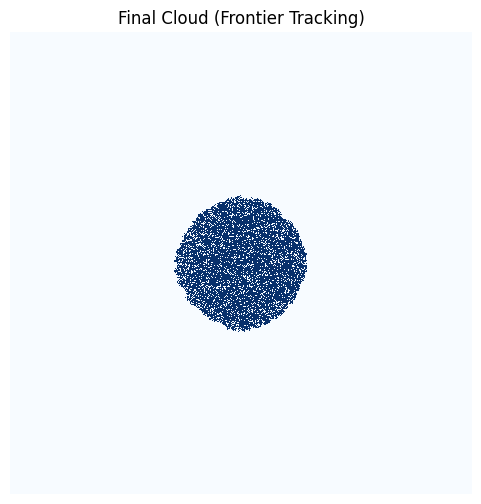

In [61]:
# Parameters
N = 2000
iterations = 500
seeds = [(N//2, N//2)]

# Custom humidity distribution (e.g., beta skewed)
humidity_fn = lambda: np.random.normal(0.5, 0.5)
# humidity_fn = lambda: 1

humidity, states, frontiers = run_simulation(N, seeds, iterations, humidity_fn=humidity_fn)

# Visualize results
plot_state(states[-1], title="Final Cloud (Frontier Tracking)")
# save_animation_with_frontier(states, frontiers)